In [66]:
# imports
import pandas as pd

In [67]:
# load data
df2009_2010 = pd.read_csv("year2009-2010.csv", encoding="latin1")
df2010_2011 = pd.read_csv("year2010-2011.csv", encoding="latin1")

In [68]:
# clean data

# rename invoice column
df2009_2010.rename(columns={df2009_2010.columns[0]: 'Invoice'}, inplace=True)
df2010_2011.rename(columns={df2010_2011.columns[0]: 'Invoice'}, inplace=True)

# remove non-customer transactions
df2010_2011 = df2010_2011.dropna(subset=['Customer ID'])
df2009_2010 = df2009_2010.dropna(subset=['Customer ID'])

In [69]:
print(df2009_2010[df2009_2010.duplicated(subset=['StockCode', 'Invoice'], keep=False)])

       Invoice StockCode                        Description  Quantity  \
289     489488     22125       UNION JACK HOT WATER BOTTLE          2   
299     489488     22125       UNION JACK HOT WATER BOTTLE          1   
362     489517     21913     VINTAGE SEASIDE JIGSAW PUZZLES         1   
363     489517     21912           VINTAGE SNAKES & LADDERS         1   
365     489517     21821   GLITTER STAR GARLAND WITH BELLS          1   
...        ...       ...                                ...       ...   
525259  538163     21479      WHITE SKULL HOT WATER BOTTLE          1   
525292  538166     21915             RED  HARMONICA IN BOX          5   
525293  538166     21915             RED  HARMONICA IN BOX          5   
525330  538168     22739  RIBBON REEL CHRISTMAS SOCK BAUBLE         5   
525340  538168     22739  RIBBON REEL CHRISTMAS SOCK BAUBLE         5   

            InvoiceDate  Price  Customer ID         Country  
289     12/1/2009 10:59   5.95      17238.0  United Kingdom  

In [70]:

#combine duplicate transactions
df2009_2010 = df2009_2010.groupby(['Invoice', 'StockCode', 'Customer ID'], as_index=False).agg({
    'Quantity': 'sum',
    'InvoiceDate': 'first',
    'Price': 'first',
    'Description': 'first',  
    'Country': 'first'       
}) 


In [78]:
# add time features 
df2009_2010['InvoiceDate'] = pd.to_datetime(df2009_2010['InvoiceDate'])
df2009_2010['TimeOfDay'] = df2009_2010['InvoiceDate'].dt.hour
df2009_2010['DayOfWeek'] = df2009_2010['InvoiceDate'].dt.day_name()

# calculate session duration
df2009_2010['SessionDuration'] = df2009_2010.groupby('Customer ID')['InvoiceDate'].diff().dt.total_seconds()

# calculate total sales amount
df2009_2010['TotalSalesAmount'] = df2009_2010['Quantity'] * df2009_2010['Price']

print(df2009_2010.columns)


Index(['Invoice', 'StockCode', 'Customer ID', 'Quantity', 'InvoiceDate',
       'Price', 'Description', 'Country', 'TimeOfDay', 'DayOfWeek',
       'SessionDuration', 'TotalSalesAmount'],
      dtype='object')


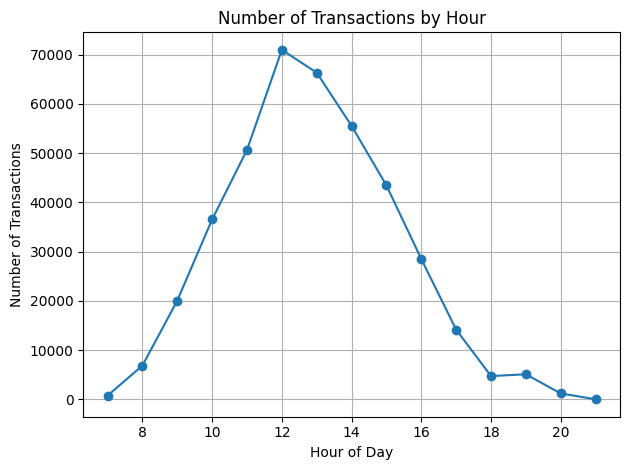

In [79]:
# visualize transactions by hour
import matplotlib.pyplot as plt
import seaborn as sns

HourlyTransactions = df2009_2010.groupby('TimeOfDay')['Invoice'].count()
HourlyTransactions.plot(kind='line', marker='o')
plt.title('Number of Transactions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()

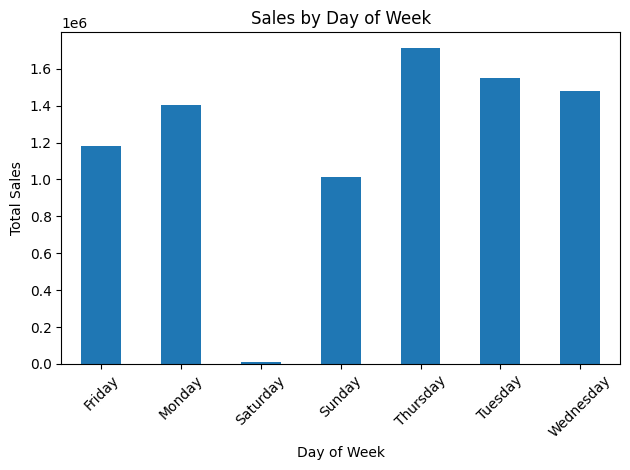

In [80]:
# visualize number of sales made according to day of week
DailySales = df2009_2010.groupby('DayOfWeek')['TotalSalesAmount'].sum()
DailySales.plot(kind='bar')
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

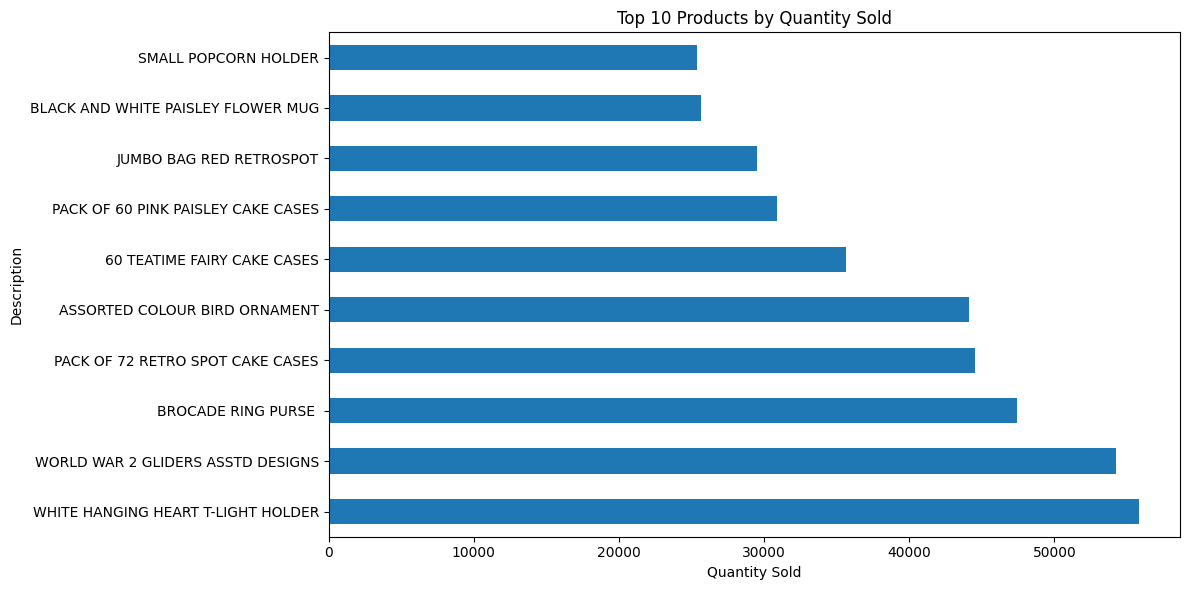

In [81]:
# determine top products sold

TopProducts = df2009_2010.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 6))
TopProducts.plot(kind='barh')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Quantity Sold')
plt.tight_layout()
plt.show()

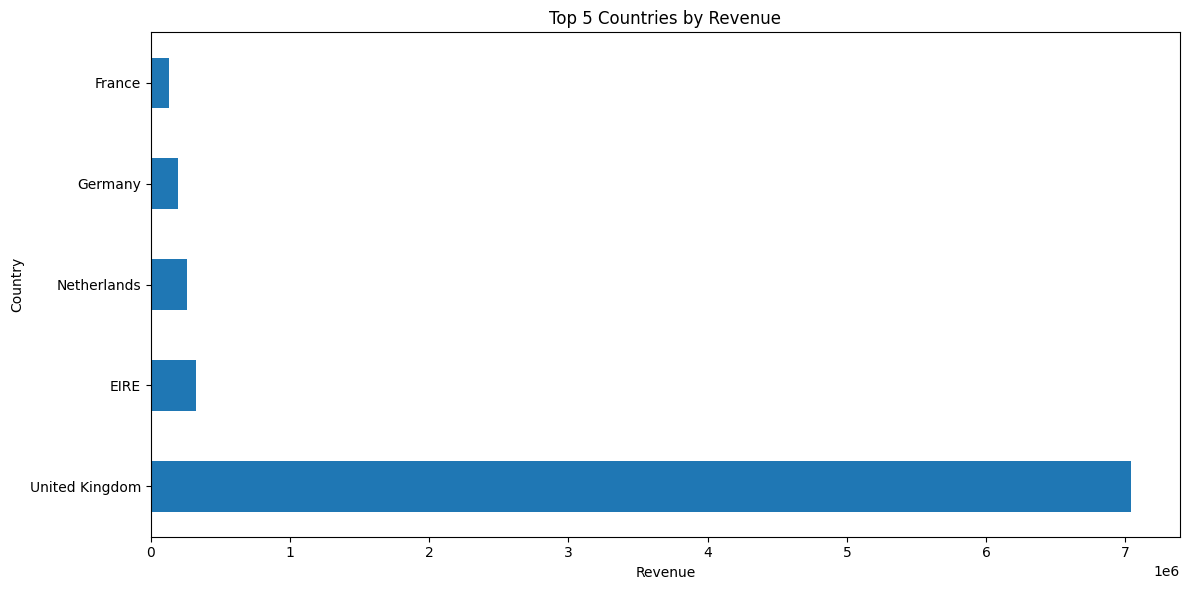

In [89]:

# countries by revenue
df2009_2010['Revenue'] = df['Quantity'] * df2009_2010['Price']
CountriesRevenue = df2009_2010.groupby('Country')['Revenue'].sum().nlargest(5)
plt.figure(figsize=(12, 6))
CountriesRevenue.plot(kind='barh')
plt.title('Top 5 Countries by Revenue')
plt.xlabel('Revenue')
plt.tight_layout()
plt.show()